##  Class of data preprocessing

In [56]:
import pandas as pd
import numpy as np

class Data_Preprocessing():
    
    def __init__(self, prefix = '../../data/'):
        self.prefix = prefix
        self.diagnoses = None
        self.measures = None
    
    # Descriptions of different kinds of diseases based on ICD_CODE
    def get_icd9codes(self,filename='D_ICD_DIAGNOSES.csv'):
        icd9_code_df = pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
        return icd9_code_df

    # Information about what diseases patients are diagnosed
    def read_diagnoses(self,filename='DIAGNOSES_ICD.csv',
                       link_filename = 'D_ICD_DIAGNOSES.csv',link_field='ICD9_CODE',
                      columns = ['SUBJECT_ID','ICD9_CODE','SHORT_TITLE','LONG_TITLE']):
        diagnose_df = pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
        diagnose_df = pd.merge(diagnose_df, self.get_icd9codes(link_filename), how='left', on=[link_field])
        self.diagnoses = diagnose_df[columns]
        
    # Pick data of specific diseases from diagnoses data
    # 4280 Congestive heart failure
    def get_labels(self, label_filed = 'ICD9_CODE', labels = ['4280'], user_field = 'SUBJECT_ID'):
        if self.diagnoses is None:
            print('Please use read_diagnoses function to get diagnose data first')
            return False
        else:
            ## TODO: What if it is required to process multiple diseases?
            filtered_diseass = self.diagnoses[self.diagnoses[label_filed].isin(labels)].drop_duplicates()
            filtered_diseass['LABEL'] = 1
            return filtered_diseass[[user_field,'LABEL']]
        
    
    ## Attributes/Phenotypes
    # Descriptions of different kinds of clinical measurements
    def get_measure_items(self,filename='D_LABITEMS.csv'):
        measure_items_df = pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
        return measure_items_df
    
    def set_measures(self,measures):
        self.measures=measures
    
    def view_data(self, filename):
        return pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
    
    ## Only run once for each data! Get most frequently occurred items and write them into files.
    def write_topitems(self,topN=100,item=['DRUG'],filename='',data=None):
        frequent_items = data.groupby(item).size().reset_index(name='counts').sort_values(ascending=0,by='counts')[:topN][[item]]
        frequent_items.to_csv(self.prefix+'temp/'+filename)
    
    # Information about what measurements patients have and values of those measurements
#     def read_measurements(self,filename = 'LABEVENTS.csv',\
#                           columns = ['LABEL','VALUE','SUBJECT_ID','VALUENUM'],\
#                           link = 'ITEMID', topN = 30):
    def read_measurements(self,data,most_frequent_labels):
#         measurements_df = pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
        
#         if(link == None):
#             measurements_df = measurements_df[columns]
            
#         else:
        ## For processing labels with values
#         measurements_df = pd.merge(measurements_df, self.get_measure_items(), how='left', on=[link])[columns]        
        label, value = 'LABEL', 'VALUE'
        ## Count frequency of each laebl, get topN most frequent labels
#         label_mostfreq_df = measurements_df.dropna(subset=[value]).groupby(label).size().\
#         reset_index(name='counts').sort_values(ascending=0,by='counts')[:topN][label]
        columns = ['LABEL','VALUE','SUBJECT_ID','VALUENUM']
        measurements_df=data
        measurements_df = measurements_df[columns].dropna(subset=[value])[measurements_df[label].isin(most_freqlabels)]
               
        self.measures = measurements_df

    
    # min_null: fields with none values more than 80% are categorical fields, otherwise continous fields.
    def get_uservectors_dict(self, fields= ['VALUE','LABEL','VALUENUM','SUBJECT_ID'], min_nulls = 0.8):
        value = fields[0]
        label_field = fields[1]
        valuenum = fields[2]
        userid = fields[3]
        labels_nulls = self.measures.dropna(subset=[value]).groupby(label_field)[valuenum].apply(lambda x: x.isnull().sum())
        
        # initiate all user vectors
#         len_all_measures = len(self.measures)
        stc_ls = ['min','mean','max','std']
        stc_ls_len = len(stc_ls)
        user_vectors = {}
        all_users = set(self.measures[userid].unique())
        for user in all_users:
            user_vectors[user] = np.empty([0])
            
        # Groupby label
        measure_label = self.measures.groupby(label_field)

        for label, label_df in measure_label:

            null_percentage = labels_nulls[label]*1.0/len(label_df)
            
            if (null_percentage<min_nulls):
                # pick one iteration of continuous label
                label_df = label_df.dropna(subset=[valuenum])

                missed_users = all_users -set(label_df[userid].unique())
                label_df_agg = label_df.groupby(userid)[valuenum].agg(stc_ls)

                for user, row in label_df_agg.iterrows():
                    if pd.isnull(row['std']): row['std']=0
                    user_vectors[user]=np.append(user_vectors[user],[row[x] for x in stc_ls])
                for user in missed_users:
                    user_vectors[user]=np.append(user_vectors[user],np.full(stc_ls_len, np.nan))
            
            else:
                # pick one iteration of discrete label
                label_df = label_df.dropna(subset=[value])
                missed_users = all_users - set(label_df[userid].unique())
                label_df_agg = label_df.groupby([userid,value])[label_field].agg(['count'])
                label_df_agg_per = label_df_agg.groupby(level=0).apply(lambda x: 100* x/float(x.sum()))

                label_df_agg_per.reset_index
                label_matrix = pd.pivot_table(label_df_agg_per,
                                              values = ['count'],index=[userid],columns=[value]).fillna(0)

                for user in label_matrix.index.get_level_values(userid):
                    user_vectors[user] = np.append(user_vectors[user],label_matrix.ix[user].values)
                for user in missed_users:
                    user_vectors[user]=np.append(user_vectors[user],np.full(label_matrix.shape[1], np.nan))
                    
        return user_vectors
                

## Randomly Select a few Patients from all of Data Source

In [57]:
data_process = Data_Preprocessing()
patients_df = data_process.view_data('PATIENTS.csv')[['SUBJECT_ID']]
selected_patients = patients_df.sample(frac=0.05)
selected_patients.head()

,SUBJECT_ID
31152,29450
19973,20265
28003,83724
13138,13489
35982,30907


In [37]:
len(selected_patients)

2326

## Feature Data(Medication)

In [38]:
import numpy as np
import re
import matplotlib.pyplot as plt

In [39]:
## Methods of Cleaning the data of DOSE_VAL_RX
digit = re.compile('[^\d-]')

def dosage_value(s):
    try:
        return float(s)
    except ValueError:
        return 0.0
    

In [40]:
#####################################################
# Medicine data

## Read Data from files and select useful columns
# dp_medication = Data_Preprocessing()
prescription_df = data_process.view_data('PRESCRIPTIONS.csv')
pres_clean_df = prescription_df[['SUBJECT_ID','DRUG','DOSE_VAL_RX','ENDDATE','STARTDATE']]
pres_clean_df = pres_clean_df.dropna(subset=['DOSE_VAL_RX'])

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [41]:
## Randomly Select Patients
pres_clean_df = pres_clean_df[pres_clean_df['SUBJECT_ID'].isin(selected_patients['SUBJECT_ID'])]
# Clean the column    
pres_clean_df.DOSE_VAL_RX = pres_clean_df.DOSE_VAL_RX.apply(lambda x: \
                                            np.average(list(map(dosage_value,digit.sub('',str(x)).split('-')))))                                
pres_clean_df.head()

,SUBJECT_ID,DRUG,DOSE_VAL_RX,ENDDATE,STARTDATE
5270,103,Amlodipine,10.0,2144-08-12 00:00:00,2144-08-12 00:00:00
5271,103,Atenolol,25.0,2144-08-12 00:00:00,2144-08-12 00:00:00
5272,103,Moexipril HCl,30.0,2144-08-12 00:00:00,2144-08-12 00:00:00
5273,103,Moexipril HCl,30.0,2144-08-13 00:00:00,2144-08-12 00:00:00
5274,103,Soln.,125.0,2144-08-13 00:00:00,2144-08-12 00:00:00


In [42]:
## Select records with topN most frequently used Drugs
most_freqdrugs = data_process.view_data('temp/TOP100_DRUGS.csv')['DRUG'][:30]
pres_mostfreq_df = pres_clean_df[pres_clean_df['DRUG'].isin(most_freqdrugs)]

## Get period for patient taking a medicine in each record (ENDDATE-STARTDATE+1) (/day)
pres_mostfreq_df['ENDDATE'] = pd.to_datetime(pres_mostfreq_df['ENDDATE'])
pres_mostfreq_df['STARTDATE'] = pd.to_datetime(pres_mostfreq_df['STARTDATE'])
pres_mostfreq_df['PERIOD']=(pres_mostfreq_df['ENDDATE']-pres_mostfreq_df['STARTDATE']).dt.days + 1

## Get average dosage for each patient taking each kind of drug
pres_sum_df = pres_mostfreq_df.groupby(['SUBJECT_ID','DRUG'])['DOSE_VAL_RX','PERIOD'].sum().reset_index()
pres_sum_df['AVG_DOSE_VAL_RX'] = pres_sum_df['DOSE_VAL_RX']/pres_sum_df['PERIOD']

## Transform dataframe to matrix (USER*DRUG)
user_prescription_vector = pd.pivot_table(pres_sum_df,index=['SUBJECT_ID'],columns=['DRUG'],values = ['AVG_DOSE_VAL_RX'])


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [43]:
user_prescription_vector.head()

AVG_DOSE_VAL_RX                                       \
DRUG       0.9% Sodium Chloride 5% Dextrose Acetaminophen    Aspirin   
SUBJECT_ID                                                             
103                         NaN         NaN    162.500000        NaN   
144                         NaN         NaN           NaN        NaN   
151                         NaN         NaN    162.500000  81.250000   
246                         NaN         NaN           NaN        NaN   
249                  145.972222       118.0    145.394737  28.513514   

                                                                    \
DRUG       Bisacodyl Calcium Gluconate         D5W Docusate Sodium   
SUBJECT_ID                                                           
103              NaN          0.800000  141.666667             NaN   
144              NaN          0.333333  125.000000             NaN   
151         3.333333          0.500000   65.789474       27.272727   
246         5.000000               NaN         NaN       33.333333   
249              NaN          0.600000  138.235294       15.384615   

                                          ...                                  \
DRUG       Fentanyl Citrate Furosemide    ...    Morphine Sulfate          NS   
SUBJECT_ID                                ...                                   
103                     NaN        NaN    ...           25.500000  120.000000   
144                     NaN        NaN    ...            0.176471  157.142857   
151                     NaN  12.000000    ...            5.625000  100.000000   
246                     NaN        NaN    ...                 NaN         NaN   
249                     NaN  18.653846    ...            0.617647  114.285714   

                                                                          \
DRUG       Pantoprazole Potassium Chloride Propofol         SW     Senna   
SUBJECT_ID                                                                 
103           10.000000          16.000000      NaN        NaN       NaN   
144                 NaN          10.000000      NaN  43.750000       NaN   
151           11.428571          11.428571      NaN  30.000000       NaN   
246           13.333333                NaN      NaN        NaN       NaN   
249           11.162791          18.000000    600.0  22.222222  0.333333   

                                                             
DRUG       Sodium Chloride 0.9%  Flush Vancomycin  Warfarin  
SUBJECT_ID                                                   
103                                NaN        NaN       NaN  
144                           0.473684        NaN       NaN  
151                                NaN        NaN       NaN  
246                           0.600000        NaN       NaN  
249                           0.512195      500.0  0.764706  

[5 rows x 30 columns]

In [113]:
plt.imshow(~user_prescription_vector.T.isna(), aspect='auto')
plt.xlabel("variables")
plt.ylabel("patients")
plt.gray()
plt.show()

In [81]:
user_prescription_vector= user_prescription_vector.fillna(0)
user_prescription_vector.head()

AVG_DOSE_VAL_RX                                       \
DRUG       0.9% Sodium Chloride 5% Dextrose Acetaminophen    Aspirin   
SUBJECT_ID                                                             
103                    0.000000         0.0    162.500000   0.000000   
144                    0.000000         0.0      0.000000   0.000000   
151                    0.000000         0.0    162.500000  81.250000   
246                    0.000000         0.0      0.000000   0.000000   
249                  145.972222       118.0    145.394737  28.513514   

                                                                    \
DRUG       Bisacodyl Calcium Gluconate         D5W Docusate Sodium   
SUBJECT_ID                                                           
103         0.000000          0.800000  141.666667        0.000000   
144         0.000000          0.333333  125.000000        0.000000   
151         3.333333          0.500000   65.789474       27.272727   
246         5.000000          0.000000    0.000000       33.333333   
249         0.000000          0.600000  138.235294       15.384615   

                                          ...                                  \
DRUG       Fentanyl Citrate Furosemide    ...    Morphine Sulfate          NS   
SUBJECT_ID                                ...                                   
103                     0.0   0.000000    ...           25.500000  120.000000   
144                     0.0   0.000000    ...            0.176471  157.142857   
151                     0.0  12.000000    ...            5.625000  100.000000   
246                     0.0   0.000000    ...            0.000000    0.000000   
249                     0.0  18.653846    ...            0.617647  114.285714   

                                                                          \
DRUG       Pantoprazole Potassium Chloride Propofol         SW     Senna   
SUBJECT_ID                                                                 
103           10.000000          16.000000      0.0   0.000000  0.000000   
144            0.000000          10.000000      0.0  43.750000  0.000000   
151           11.428571          11.428571      0.0  30.000000  0.000000   
246           13.333333           0.000000      0.0   0.000000  0.000000   
249           11.162791          18.000000    600.0  22.222222  0.333333   

                                                             
DRUG       Sodium Chloride 0.9%  Flush Vancomycin  Warfarin  
SUBJECT_ID                                                   
103                           0.000000        0.0  0.000000  
144                           0.473684        0.0  0.000000  
151                           0.000000        0.0  0.000000  
246                           0.600000        0.0  0.000000  
249                           0.512195      500.0  0.764706  

[5 rows x 30 columns]

## Feature Data (Use Labevents rather than Charevents)

In [45]:
data=pd.merge(data_process.view_data('LABEVENTS.csv'), data_process.get_measure_items(), how='left', on=['ITEMID'])

In [46]:
######################################################
# Lab ICD9
# data_preprocessing = Data_Preprocessing()
# data_process.read_measurements()
# data_preprocessing.measures.head()

## Select records with topN most frequently used LABELS
# measure_mostfreq_df = data_process.read_measurements(data, most_freqlabels)

# user_vectors = data_preprocessing.get_uservectors_dict()
# labevent_items_df = pd.read_csv('../../data/D_LABITEMS.csv', sep=',', encoding='latin1')
# labevent_cols = ['SUBJECT_ID','VALUE','VALUENUM','LABEL']
# labevent_detailed_df = pd.merge(labevent_df, labevent_items_df, how='left', on=['ITEMID'])[labevent_cols]
# labevent_detailed_df.sort_values(by='SUBJECT_ID')[:10]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [54]:
## Select records with most frequently used labels
most_freqlabels = data_process.view_data('temp/TOP100_LABELS.csv')['LABEL'][:30]
columns = ['SUBJECT_ID','LABEL','VALUE','VALUENUM']
measre_clean_df = data[columns].dropna(subset=['VALUE'])[data['LABEL'].isin(most_freqlabels)]
measre_clean_df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,SUBJECT_ID,LABEL,VALUE,VALUENUM
0,3,pH,7.39,7.39
1,3,SPECIMEN TYPE,ART,NaN
2,3,Base Excess,-1,-1.00
3,3,Calculated Total CO2,22,22.00
4,3,Free Calcium,0.93,0.93


In [60]:
## Randomly Select Patients
measre_clean_df = measre_clean_df[measre_clean_df['SUBJECT_ID'].isin(selected_patients['SUBJECT_ID'])]

## Reset measures for extracting patient vectors
data_process.set_measures(measre_clean_df)
user_vectors = data_process.get_uservectors_dict()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [74]:
user_dataframe = pd.DataFrame(user_vectors).T.dropna(axis=0,how='all').sort_index()
user_dataframe.sort_index().dropna(how='all').head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
103,11.0,14.250000,21.0,3.105295,-1.0,0.0,1.0,1.000000,20.0,22.750000,...,34.0,4.041452,7.0,7.352500,7.50,0.237680,68.0,103.000,147.0,40.261644
144,12.0,14.090909,16.0,1.044466,-1.0,0.0,2.0,0.925820,23.0,24.000000,...,42.0,2.390457,5.0,6.887273,7.46,0.971814,96.0,177.125,368.0,89.197113
151,11.0,14.375000,17.0,2.125245,-3.0,-1.2,2.0,1.619328,19.0,22.562500,...,47.0,5.159673,6.0,7.256667,7.50,0.378729,76.0,191.000,357.0,99.488693
215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,6.0,10.809524,17.0,3.026864,-3.0,-1.0,1.0,1.825742,22.0,27.333333,...,37.0,2.500000,5.0,6.926000,7.43,1.076908,196.0,211.000,224.0,12.489996


In [102]:
MAX_NULLS = 0.5
user_dataframe['NULL%'] = user_dataframe.isnull().sum(axis=1)/user_dataframe.shape[1]

In [103]:
## Drop rows with too many null values
user_cleandf = user_dataframe[user_dataframe['NULL%']<MAX_NULLS]
user_cleandf = user_cleandf.drop(['NULL%'],axis=1)
user_cleandf.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
103,11.0,14.250000,21.0,3.105295,-1.0,0.00,1.0,1.000000,20.0,22.750000,...,34.0,4.041452,7.0,7.352500,7.50,0.237680,68.0,103.000,147.0,40.261644
144,12.0,14.090909,16.0,1.044466,-1.0,0.00,2.0,0.925820,23.0,24.000000,...,42.0,2.390457,5.0,6.887273,7.46,0.971814,96.0,177.125,368.0,89.197113
151,11.0,14.375000,17.0,2.125245,-3.0,-1.20,2.0,1.619328,19.0,22.562500,...,47.0,5.159673,6.0,7.256667,7.50,0.378729,76.0,191.000,357.0,99.488693
246,6.0,10.809524,17.0,3.026864,-3.0,-1.00,1.0,1.825742,22.0,27.333333,...,37.0,2.500000,5.0,6.926000,7.43,1.076908,196.0,211.000,224.0,12.489996
249,8.0,13.580645,20.0,2.961769,-1.0,4.36,13.0,4.101626,19.0,27.532258,...,80.0,9.920853,5.0,6.907941,7.52,0.879334,77.0,163.600,515.0,99.789779


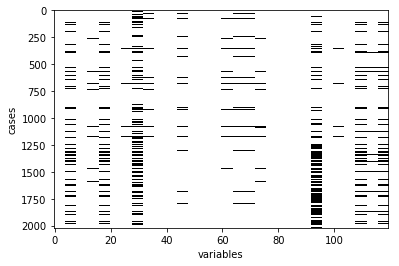

In [105]:
plt.imshow(~user_cleandf.isna(), aspect='auto')
plt.xlabel("variables")
plt.ylabel("cases")
plt.gray()
plt.show()

## MICE Imputation

In [108]:
print("Patients in Prescription: %d" % len(user_prescription_vector))
print("Patients in Body_index: %d" % len(user_cleandf))

Patients in Prescription: 1879
Patients in Body_index: 2020


In [126]:
## Rename columns in prescription data
num_pres, num_bodyindex = user_prescription_vector.shape[1],user_cleandf.shape[1]
user_prescription_vector.columns = [i for i in range(num_bodyindex,num_pres+num_bodyindex)]

In [127]:
final_patient_vector = pd.concat([user_cleandf,user_prescription_vector], axis=1, sort=False)
final_patient_vector.head()
## TODO: REMOVE Patients with very few data

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
103,11.0,14.250000,21.0,3.105295,-1.0,0.00,1.0,1.000000,20.0,22.750000,...,25.500000,120.000000,10.000000,16.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
144,12.0,14.090909,16.0,1.044466,-1.0,0.00,2.0,0.925820,23.0,24.000000,...,0.176471,157.142857,0.000000,10.000000,0.0,43.750000,0.000000,0.473684,0.0,0.000000
151,11.0,14.375000,17.0,2.125245,-3.0,-1.20,2.0,1.619328,19.0,22.562500,...,5.625000,100.000000,11.428571,11.428571,0.0,30.000000,0.000000,0.000000,0.0,0.000000
246,6.0,10.809524,17.0,3.026864,-3.0,-1.00,1.0,1.825742,22.0,27.333333,...,0.000000,0.000000,13.333333,0.000000,0.0,0.000000,0.000000,0.600000,0.0,0.000000
249,8.0,13.580645,20.0,2.961769,-1.0,4.36,13.0,4.101626,19.0,27.532258,...,0.617647,114.285714,11.162791,18.000000,600.0,22.222222,0.333333,0.512195,500.0,0.764706


In [ ]:
#############################################################
## MICE imputation
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

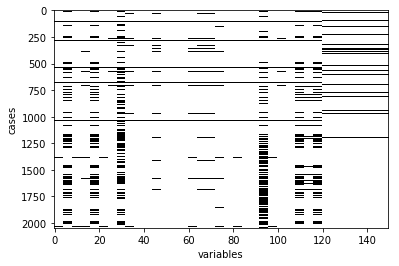

In [128]:
plt.imshow(~final_patient_vector.isna(), aspect='auto')
plt.xlabel("variables")
plt.ylabel("cases")
plt.gray()
plt.show()

In [146]:
## For mice model, column name should be string instead of numeric type.
final_patient_vector.columns = ['X'+str(i) for i in final_patient_vector.columns]
final_patient_vector.head()

,XX0,XX1,XX2,XX3,XX4,XX5,XX6,XX7,XX8,XX9,...,XX140,XX141,XX142,XX143,XX144,XX145,XX146,XX147,XX148,XX149
103,11.0,14.250000,21.0,3.105295,-1.0,0.00,1.0,1.000000,20.0,22.750000,...,25.500000,120.000000,10.000000,16.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
144,12.0,14.090909,16.0,1.044466,-1.0,0.00,2.0,0.925820,23.0,24.000000,...,0.176471,157.142857,0.000000,10.000000,0.0,43.750000,0.000000,0.473684,0.0,0.000000
151,11.0,14.375000,17.0,2.125245,-3.0,-1.20,2.0,1.619328,19.0,22.562500,...,5.625000,100.000000,11.428571,11.428571,0.0,30.000000,0.000000,0.000000,0.0,0.000000
246,6.0,10.809524,17.0,3.026864,-3.0,-1.00,1.0,1.825742,22.0,27.333333,...,0.000000,0.000000,13.333333,0.000000,0.0,0.000000,0.000000,0.600000,0.0,0.000000
249,8.0,13.580645,20.0,2.961769,-1.0,4.36,13.0,4.101626,19.0,27.532258,...,0.617647,114.285714,11.162791,18.000000,600.0,22.222222,0.333333,0.512195,500.0,0.764706


In [137]:
import statsmodels.imputation.mice as smi
formula = 'X0 - ' + ' + '.join(final_patient_vector.columns[1:])
print("The formula for MICE is \"%s\"]." % formula)
imp = smi.set_imputer('X0',' + '.join(final_patient_vector.columns[1:]))
# mmod = smi.MICE(formula, smi.OLS, imp)

In [ ]:
############################################################################################################

In [139]:
## Fill na with means
## TODO imputation
patient_final_df = final_patient_vector.fillna(final_patient_vector.mean())
# patient_final_df
patient_final_df.head()
# any(np.isnan(patient_final_vector.fillna(0)))

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149
103,11.0,14.250000,21.0,3.105295,-1.0,0.00,1.0,1.000000,20.0,22.750000,...,25.500000,120.000000,10.000000,16.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
144,12.0,14.090909,16.0,1.044466,-1.0,0.00,2.0,0.925820,23.0,24.000000,...,0.176471,157.142857,0.000000,10.000000,0.0,43.750000,0.000000,0.473684,0.0,0.000000
151,11.0,14.375000,17.0,2.125245,-3.0,-1.20,2.0,1.619328,19.0,22.562500,...,5.625000,100.000000,11.428571,11.428571,0.0,30.000000,0.000000,0.000000,0.0,0.000000
246,6.0,10.809524,17.0,3.026864,-3.0,-1.00,1.0,1.825742,22.0,27.333333,...,0.000000,0.000000,13.333333,0.000000,0.0,0.000000,0.000000,0.600000,0.0,0.000000
249,8.0,13.580645,20.0,2.961769,-1.0,4.36,13.0,4.101626,19.0,27.532258,...,0.617647,114.285714,11.162791,18.000000,600.0,22.222222,0.333333,0.512195,500.0,0.764706


In [140]:
data_process.read_diagnoses()
actual_label = data_process.get_labels()
actual_label.sort_values(by='SUBJECT_ID').head()

,SUBJECT_ID,LABEL
616,3,1
651,9,1
724,21,1
793,26,1
844,34,1


In [141]:
## get labels for patients in measurement data
all_users_list = pd.DataFrame({'SUBJECT_ID': patient_final_df.index})

actual_labels = pd.merge(all_users_list,actual_label,how='left',on='SUBJECT_ID')
len(actual_labels)
actual_labels = actual_labels.fillna(0)
actual_labels.head()

,SUBJECT_ID,LABEL
0,103,0.0
1,144,0.0
2,151,1.0
3,246,0.0
4,249,1.0


In [142]:
len(all_users_list)

2045

## Train cluster model

In [154]:
np.all(np.isfinite(patient_final_df))

False

In [145]:
from sklearn.cluster import KMeans

# TODO: check 4 labels remove null values, 4 columns
patient_final_df = patient_final_df.dropna(axis=1)

kmeans = KMeans(n_clusters=2, random_state=0).fit(patient_final_df)
kmeans.labels_

kmeans.cluster_centers_

y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(patient_final_df)
y_pred
from collections import Counter
Counter(y_pred).values()
# list(set(y_pred))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## read diagnose information

In [ ]:
data_preprocessing = Data_Preprocessing()
data_preprocessing.read_diagnoses()
# data_preprocessing.diagnoses.head()
data_preprocessing.diagnoses.head()
data_preprocessing.get_labels().head()

## Embedding and Plotting

In [ ]:
## TSNE is too slow

# from sklearn.manifold import TSNE
# X_embedded = TSNE(n_components=2, learning_rate=3000).fit_transform(user_cleandf)

# plt.figure(figsize=(15, 15))
# plt.scatter(X_embedded[:,0],X_embedded[:,1],c=y_pred)
# plt.title("KMeans")
# plt.show()

In [ ]:
## all data
import umap
# from sklearn.datasets import load_digits

# digits = load_digits()

embedding = umap.UMAP().fit_transform(user_finaldf)

actual_labels['LABEL'] = actual_labels['LABEL'].astype(int)
actual_labels['PREDICTED']=y_pred
actual_labels['X0']=embedding[:,0]
actual_labels['X1']=embedding[:,1]
# actual_labels[:10]
# pd.concat([y_pred, actual_labels['LABEL'].astype(int)],axis=1).head()
# embedding.tolist()
true_X = actual_labels[actual_labels['LABEL']==0]
false_X = actual_labels[actual_labels['LABEL']==1]
# true_X.head()
# true_X['LABEL'].head()

In [ ]:
## randomly select samples for plot
all_user_label_df = user_finaldf
all_user_label_df['ACTUAL'] = actual_labels['LABEL']
all_user_label_df['PRED'] = y_pred
all_label_df = all_user_label_df.dropna(axis =0)

In [ ]:
heart_failure_df = all_label_df[all_label_df['ACTUAL']==1].sample(frac=0.3)
normal_df = all_label_df[all_label_df['ACTUAL']==0].sample(frac=0.15)
random_sample_df = heart_failure_df.append(normal_df)
random_sample_df.head()

In [ ]:
random_embedding = umap.UMAP().fit_transform(random_sample_df.drop(['ACTUAL','PRED'],axis=1))

random_label_df = random_sample_df[['ACTUAL','PRED']]
# actual_labels['LABEL'] = actual_labels['LABEL'].astype(int)
# actual_labels['PREDICTED']=y_pred
random_label_df['X0']=random_embedding[:,0]
random_label_df['X1']=random_embedding[:,1]
# actual_labels[:10]
# pd.concat([y_pred, actual_labels['LABEL'].astype(int)],axis=1).head()
# embedding.tolist()
random_true_X = random_label_df[random_label_df['ACTUAL']==0]
random_false_X = random_label_df[random_label_df['ACTUAL']==1]

In [ ]:
len(random_sample_df)

In [ ]:
import matplotlib.pyplot as plt

def plot_cluster(true_X, false_X, PRED = 'PREDICTED'):
    colors = ['b','y']

    # marker=[markers[x] for x in actual_labels['LABEL'].astype(int)]
    plt.figure(figsize=(15, 15))
    # for i in range(len(embedding)):
    #     plt.scatter(embedding[i,0], embedding[i,1], 
    #                 c = colors[y_pred[i]], 
    #                 marker = markers[int(actual_labels['LABEL'][i])])
    # v: Label indicates heart failure
    plt.scatter(true_X['X0'],true_X['X1'],c=[colors[x] for x in true_X[PRED]],marker="v",s=50)
    plt.scatter(false_X['X0'],false_X['X1'],c=[colors[x] for x in false_X[PRED]],marker="+",s=50)
    #             ,marker=actual_labels['LABEL'].astype(int))
    # [markers[x] for x in actual_labels['LABEL'].astype(int)]

    plt.title("KMeans")
    plt.show()

In [ ]:
plot_cluster(true_X,false_X)

In [ ]:
plot_cluster(random_true_X,random_false_X,'PRED')

In [ ]:
type(y_pred)

## Crafts

In [ ]:
# // TODO
# feature_filtered_df = labevent_detailed_df[(labevent_detailed_df.LABEL == 'Blasts')] 
labevent_detailed_df[(labevent_detailed_df.LABEL == 'pH')].sort_values(by='SUBJECT_ID')

In [ ]:
# initiate all user vectors
con_stc_ls = ['min','mean','max','std']
con_stc_ls_len = len(con_stc_ls)

user_vectors = {}
all_users = set(labevent_detailed_df['SUBJECT_ID'].unique())
for user in all_users:
    user_vectors[user] = np.empty([0])
    

In [ ]:
# pick one iteration of continuous label
wbc = labevent_detailed_df[labevent_detailed_df['LABEL']=='WBC']
wbc_agg = wbc.dropna(subset=['VALUENUM']).groupby('SUBJECT_ID')['VALUENUM'].agg(con_stc_ls)
wbc_agg.head()
# wbc_agg[:10]
# wbc[wbc['SUBJECT_ID']==4][:10]

current_users = set(wbc['SUBJECT_ID'].unique())
missed_users = all_users - current_users

for user, row in wbc_agg.iterrows():
    if pd.isnull(row['std']): row['std']=0
    user_vectors[user]=np.append(user_vectors[user],[row[x] for x in con_stc_ls])
for user in missed_users:
    user_vectors[user]=np.append(user_vectors[user],np.full(con_stc_ls_len, np.nan))

In [ ]:
# all_users = labevent_detailed_df['SUBJECT_ID'].unique() 
# print(len(set(all_users)- set(wbc['SUBJECT_ID'].unique())))
# print(len(all_users))
# np.full(3, np.nan)
# np.append(np.array([1]),[2,3])
# user_vectors[5]
# wbc = labevent_detailed_df[labevent_detailed_df['LABEL']=='WBC']
ani_agg.head()


In [ ]:
# pick one iteration of discrete label
ani = labevent_detailed_df[labevent_detailed_df['LABEL']=='Anisocytosis']
ani_agg = ani.dropna(subset=['VALUE']).groupby(['SUBJECT_ID','VALUE'])['LABEL'].agg(['count'])
ani_agg_per = ani_agg.groupby(level=0).apply(lambda x: 100* x/float(x.sum()))
current_users = set(ani['SUBJECT_ID'].unique())
missed_users = all_users - current_users

ani_agg_per.reset_index
ani_matrix = pd.pivot_table(ani_agg_per,values = ['count'],index=['SUBJECT_ID'],columns=['VALUE'])

ani_matrix = ani_matrix.fillna(0)
for user in ani_matrix.index.get_level_values('SUBJECT_ID')[:10]:
    user_vectors[user] = np.append(user_vectors[user],ani_matrix.ix[user].values)
for user in missed_users:
    user_vectors[user]=np.append(user_vectors[user],np.full(ani_matrix.shape[1], np.nan))
# ani_matrix.head() 
# ani_matrix.shape[1]

In [ ]:
final_feature_df = feature_filtered_df[['SUBJECT_ID','CHARTTIME','VALUENUM']]
# Remove Nan data
final_feature_df = final_feature_df[final_feature_df.VALUENUM.notna()]
final_feature_df[:10]

In [ ]:
final_feature_df['CHAR_DATE'] = final_feature_df['CHARTTIME'].dt.date
final_feature_df[:10]

In [ ]:

final_feature_bydate_df = final_feature_df.groupby(['SUBJECT_ID','CHAR_DATE']).agg({"VALUENUM": "mean"})

final_feature_bydate_df = final_feature_bydate_df.reset_index().sort_values(by=['SUBJECT_ID','CHAR_DATE'])

final_feature_bydate_df['SHIFT_DATE'] = final_feature_bydate_df.groupby('SUBJECT_ID')['CHAR_DATE'].apply(lambda i:i.shift(1))
final_feature_bydate_df[:10]

In [ ]:
final_feature_bydate_df['DATE_INTERVAL'] = (final_feature_bydate_df['CHAR_DATE']
                                           - final_feature_bydate_df['SHIFT_DATE']).dt.days

## remove those subjects not in feature dataframe


In [ ]:
final_label_df = final_label_df[final_label_df['SUBJECT_ID'].isin(final_feature_bydate_df['SUBJECT_ID'])]

In [ ]:
subject_label = {}
subject_label = final_label_df.set_index('SUBJECT_ID').to_dict('index')
for key in subject_label:
    subject_label[key] = subject_label[key]['CONGESTIVE_HEART_FAILURE']

In [ ]:
num_attrs = 25
current_vector = np.zeros(num_attrs, dtype=float)
current_index = 0
current_subject = final_feature_bydate_df["SUBJECT_ID"][0]
subject_dict = {}


for index, row in final_feature_bydate_df.iterrows():
    # if not in the begining of a group, increase index by date interval
    if not (pd.isnull(row["DATE_INTERVAL"])):
        current_index += row["DATE_INTERVAL"]
        
    if row["SUBJECT_ID"] != current_subject: 

        subject_dict[current_subject] = current_vector
        current_vector = np.zeros(num_attrs, dtype=float)
        if current_subject not in subject_label:
            subject_label[current_subject]= '0'
        
        current_index = 0
        current_subject = row["SUBJECT_ID"]
        
    if current_index >= 25: continue
    current_vector[int(current_index)]= row["VALUENUM"]

subject_dict[current_subject] = current_vector
if current_subject not in subject_label:
    subject_label[current_subject]='0'

## t-SNE

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

max_train = 5000
train_dict_keys = random.sample(list(subject_dict.keys()), max_train)
## Get X and y
X = np.empty(shape=(max_train,max_attrs))
y = np.empty(shape=(max_train))

i=0
for k in train_dict_keys:
    X[i]=subject_dict[k]
    y[i]=subject_label[k]
    i+=1   
    
X_embedded = TSNE(n_components=2, learning_rate=3000).fit_transform(X)

In [ ]:
plt.figure(figsize=(15, 15))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=y, s=10, alpha = 1)

plt.show()